In [1]:
import uproot as up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vector
import zfit
import mplhep as hep
import yaml
import seaborn as sns
import particle
hep.style.use('ATLAS')

/Users/claudiumihai/mambaforge/envs/mphys/lib/python3.10/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
tree=up.open('Wy_CMS_100.root:Delphes')
with open('all_keys.yaml','w') as file:
    yaml.safe_dump(tree.keys(),file)
tree_2=up.open('Wy_CMS_50.root:Delphes')

In [3]:
base_features=['_size','.PT','.Eta','.Phi']
particles=['Muon','Electron','Photon']
neutrino_features=['MissingET.MET','MissingET.Eta','MissingET.Phi','MissingET_size']+['Jet_size','Jet.PT','Jet.Eta']
event_features=[i+j for i in particles for j in base_features]+neutrino_features
events_df=pd.concat([tree.arrays(event_features,library="pd"),tree_2.arrays(event_features,library="pd")],axis=0,ignore_index=True)



FILE_SIZE=len(events_df)




In [4]:
events_df

,Muon_size,Muon.PT,Muon.Eta,Muon.Phi,Electron_size,Electron.PT,Electron.Eta,Electron.Phi,Photon_size,Photon.PT,Photon.Eta,Photon.Phi,MissingET.MET,MissingET.Eta,MissingET.Phi,MissingET_size,Jet_size,Jet.PT,Jet.Eta
0,1,[28.15080451965332],[-0.5528598427772522],[0.34539875388145447],0,[],[],[],1,[67.26831817626953],[-1.942108392715454],[2.7962253093719482],[47.51692199707031],[3.154902696609497],[-0.549392819404602],1,0,[],[]
1,0,[],[],[],0,[],[],[],1,[29.47099494934082],[2.284233331680298],[-3.0970327854156494],[54.54691696166992],[-3.290689706802368],[-0.5138919353485107],1,1,[28.614877700805664],[1.661072015762329]
2,0,[],[],[],1,[42.32748794555664],[0.1594109833240509],[-0.9018970131874084],1,[73.95552825927734],[1.855893850326538],[1.6892973184585571],[66.38700866699219],[-2.4135093688964844],[-2.0255489349365234],1,0,[],[]
3,0,[],[],[],0,[],[],[],0,[],[],[],[55.8874397277832],[2.7844178676605225],[2.8508293628692627],1,3,"[60.06157302856445, 43.15861511230469, 30.2251...","[0.4195238947868347, 2.2176733016967773, -1.95..."
4,1,[32.55332565307617],[-1.909653902053833],[-2.7426748275756836],0,[],[],[],1,[45.55385208129883],[0.1063452810049057],[2.1218948364257812],[53.07987976074219],[1.8414852619171143],[-0.3101428747177124],1,0,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,[],[],[],0,[],[],[],1,[35.75580978393555],[1.3562397956848145],[1.8232160806655884],[40.26090621948242],[-3.5343945026397705],[-2.479661464691162],1,1,[31.620098114013672],[-1.6591823101043701]
149996,1,[34.30208206176758],[1.2130990028381348],[-0.6556219458580017],0,[],[],[],1,[140.51295471191406],[2.0596306324005127],[-1.223740816116333],[117.78644561767578],[-4.036861419677734],[1.7164597511291504],1,1,[71.20103454589844],[4.235019683837891]
149997,0,[],[],[],0,[],[],[],1,[73.24433898925781],[0.005995477549731731],[-2.053192138671875],[69.47793579101562],[-1.670327067375183],[1.4390902519226074],1,1,[45.920711517333984],[0.969152569770813]
149998,0,[],[],[],0,[],[],[],1,[99.45120239257812],[-0.7536826133728027],[1.0498684644699097],[64.82425689697266],[-1.6979386806488037],[-2.0219123363494873],1,2,"[38.2166633605957, 23.12189292907715]","[1.3064417839050293, -0.9680911302566528]"


In [5]:
events_df=events_df.loc[ ((events_df['Photon_size']==1) & (events_df['MissingET_size']==1) & ((events_df['Muon_size']==1)) & ( events_df['Electron_size']==0 ) ) |
                           ((events_df['Photon_size']==1) & (events_df['MissingET_size']==1) & ((events_df['Electron_size']==1))   &( events_df['Muon_size']==0) )  ]

In [6]:
def extract_single_element(x):
    if isinstance(x, list) or isinstance(x,np.ndarray):
        if len(x) == 1:
            return x[0]
        elif len(x)==0:
            return np.nan
        elif len(x)>1:
            return np.array(x)
    elif isinstance(x, (np.float32, np.float64, float,int)): 
        return x
    else:
        return np.nan  # If
events_df = events_df.map(extract_single_element)

In [7]:
CMS_cut=events_df.loc[(events_df['MissingET.MET']>40) &(events_df['Photon.PT']>30) & (np.abs(events_df['Photon.Eta'])<2.5)&
              
              ( (events_df['Electron.PT']>35) | (events_df['Muon.PT']>30) ) 
             &
               (  (    (np.abs(events_df['Electron.Eta'])<1.44) | (np.abs(events_df['Electron.Eta'])>1.57)      &  
                       (np.abs(events_df['Electron.Eta'])<2.5)    )          | (np.abs(events_df['Muon.Eta'])<2.4)  )  
               
                &(    (  np.sqrt((events_df['Electron.Eta'] - events_df['Photon.Eta'])**2 +(events_df['Electron.Phi'] -events_df['Photon.Phi'] )**2  )>0.7
                       )  |
                       ( np.sqrt((events_df['Muon.Eta'] - events_df['Photon.Eta'])**2 +(events_df['Muon.Phi'] -events_df['Photon.Phi'] )**2  )>0.7)       )
              ].copy()
CMS_cut['lepton_mass']=0.0
CMS_cut.loc[CMS_cut['Muon_size']==1,'lepton_mass']=particle.Particle.from_pdgid(13).mass/1000
CMS_cut.loc[CMS_cut['Electron_size']==1,'lepton_mass']=particle.Particle.from_pdgid(11).mass/1000

CMS_cut['M_ly']=0.0

CMS_cut.loc[CMS_cut['Muon_size']==1,'M_ly']=np.sqrt(       
    (CMS_cut['Photon.PT']*np.cosh(CMS_cut['Photon.Eta'])  + np.sqrt(   (CMS_cut['Muon.PT']*np.cosh(CMS_cut['Muon.Eta']))**2+CMS_cut['lepton_mass']**2    )  )**2  
        - (   CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi'])  )**2
        - (   CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi'])  )**2
        - (   CMS_cut['Muon.PT']*np.sinh(CMS_cut['Muon.Eta']) +CMS_cut['Photon.PT']*np.sinh(CMS_cut['Photon.Eta'])  )**2
            )
CMS_cut.loc[CMS_cut['Electron_size']==1,'M_ly']=np.sqrt(       
    (CMS_cut['Photon.PT']*np.cosh(CMS_cut['Photon.Eta'])  + np.sqrt(   (CMS_cut['Electron.PT']*np.cosh(CMS_cut['Electron.Eta']))**2+CMS_cut['lepton_mass']**2    )  )**2  
        - (   CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi'])  )**2
        - (   CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi'])  )**2
        - (   CMS_cut['Electron.PT']*np.sinh(CMS_cut['Electron.Eta']) +CMS_cut['Photon.PT']*np.sinh(CMS_cut['Photon.Eta'])  )**2
            )




In [8]:
CMS_cut=CMS_cut.loc[   (((CMS_cut['M_ly']<70)|(CMS_cut['M_ly']>110)  ) & (CMS_cut['Electron_size']==1)) |
                 (((CMS_cut['M_ly']<70)|(CMS_cut['M_ly']>100)  ) & (CMS_cut['Muon_size']==1))
].copy()

In [9]:
CMS_cut['Mt_lv']=0.0


CMS_cut.loc[CMS_cut['Electron_size']==1,'Mt_lv']=np.sqrt(  
    ( CMS_cut['MissingET.MET']+ np.sqrt((CMS_cut['Electron.PT'])**2+CMS_cut['lepton_mass']**2))**2 
    - (   CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi'])  )**2
        - (   CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi'])  )**2   )

CMS_cut.loc[CMS_cut['Muon_size']==1,'Mt_lv']=np.sqrt(  
    ( CMS_cut['MissingET.MET']+ np.sqrt((CMS_cut['Muon.PT'])**2+CMS_cut['lepton_mass']**2))**2 
    - (   CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi'])  )**2
        - (   CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi'])  )**2   )

In [10]:
def is_valid_greater(value, threshold):
    if isinstance(value, np.ndarray):  # First check if it's an array
        return np.all(value >threshold)
    elif pd.isna(value):  # Then check if it's NaN (this will now only apply to non-arrays)
        return True  # Keep NaN values
    elif isinstance(value, (int, float)):  # Check if it's a scalar number
        return value >threshold
    return False
    
    
def is_valid_lesser(value, threshold):
    if isinstance(value, np.ndarray):  # First check if it's an array
        return np.all(value <threshold)
    elif pd.isna(value):  # Then check if it's NaN (this will now only apply to non-arrays)
        return True  # Keep NaN values
    elif isinstance(value, (int, float)):  # Check if it's a scalar number
        return value <threshold
    return False
    

CMS_cut = CMS_cut[CMS_cut['Jet.PT'].apply(lambda x: is_valid_greater(x, 30))]

CMS_cut = CMS_cut[CMS_cut['Jet.Eta'].apply(lambda x: is_valid_lesser(x, 2.5))]




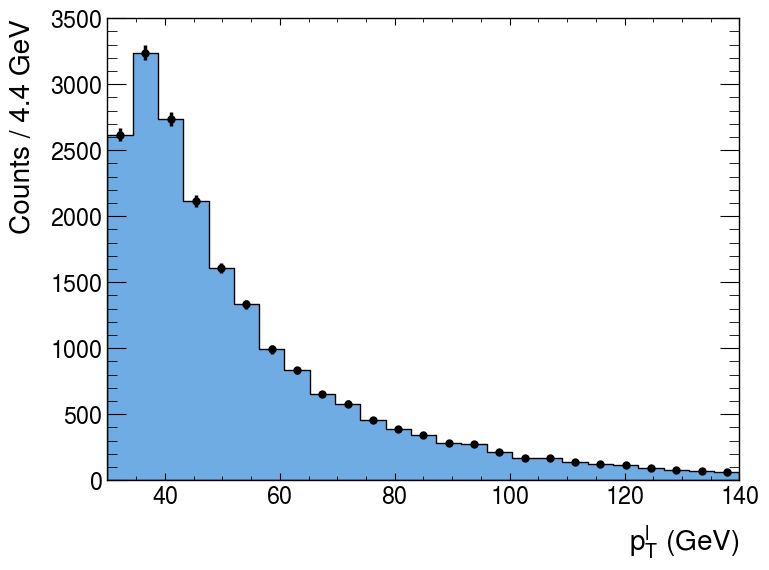

In [11]:
Pt_lepton=pd.concat([CMS_cut['Muon.PT'],CMS_cut['Electron.PT']],axis=0,ignore_index=True)
hep.style.use('ATLAS')
var=Pt_lepton

counts, bins = np.histogram(var, 25,range=(30, 140))
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
plt.figure()
sns.histplot(var,bins=25,element='step',binrange=[30,140],edgecolor='black')
plt.errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')

plt.xlim(30,140)
plt.ylabel('Counts / 4.4 GeV')
plt.xlabel(r'$\mathrm{p_{T}^{l}}$'+' (GeV)')
plt.show()

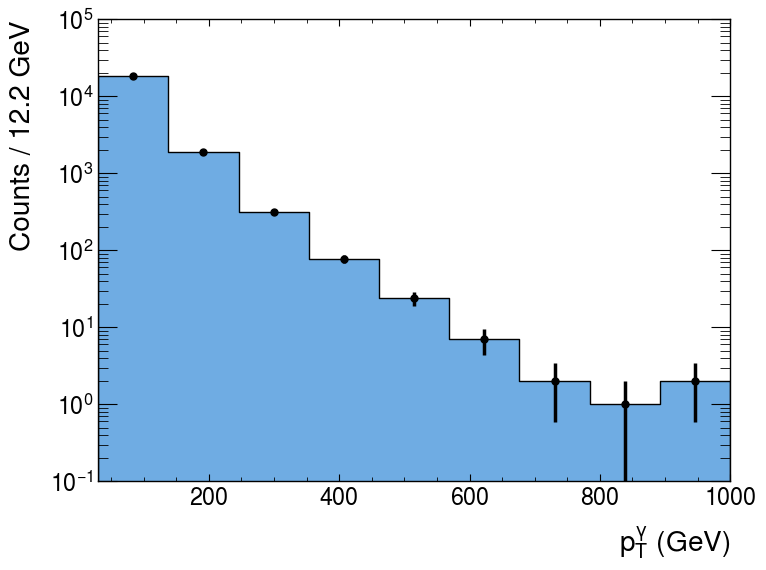

In [12]:
Pt_photon=CMS_cut['Photon.PT']
hep.style.use('ATLAS')
var=Pt_photon

counts, bins = np.histogram(var, 9,range=(30, 1000))
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
plt.figure()
sns.histplot(var,bins=9,element='step',edgecolor='black',binrange=[30,1000])
plt.errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
plt.yscale('log')
plt.ylabel('Counts / 12.2 GeV')
plt.xlabel(r'$\mathrm{p_{T}^{\gamma}}$'+' (GeV)')
plt.xlim(30,1000)
plt.show()

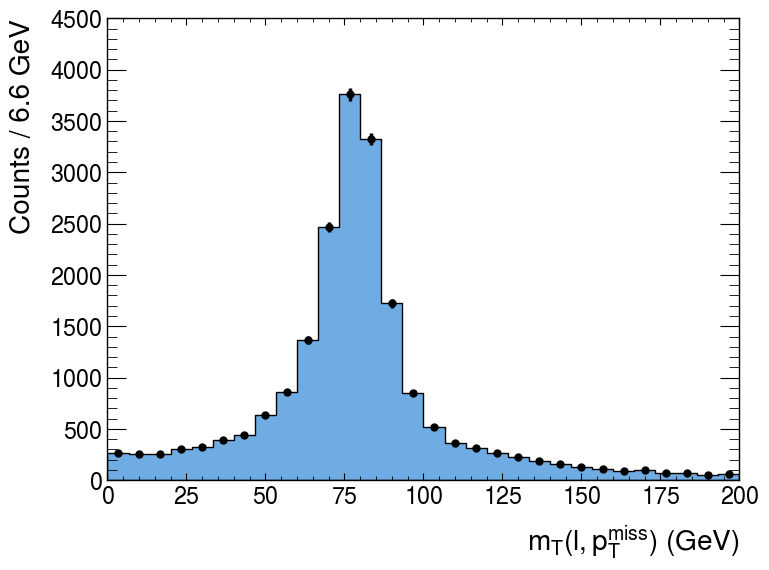

In [13]:
hep.style.use('ATLAS')
var=CMS_cut['Mt_lv']

counts, bins = np.histogram(var, 30,range=(0, 200))
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
plt.figure()
sns.histplot(var,bins=30,element='step',edgecolor='black',binrange=[0,200])
plt.errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
plt.ylabel('Counts / 6.6 GeV')
plt.xlabel(r'$\mathrm{m_{T}(l,p_{T}^{miss})}$'+' (GeV)')
plt.show()

In [14]:
CMS_cut['Mt_cluster']=0.0

CMS_cut.loc[CMS_cut['Electron_size']==1,'Mt_cluster']=np.sqrt(  (np.sqrt( CMS_cut['M_ly']**2  +
                                                                         (CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi'])  )**2 + 
                                                                         (CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi'])  )**2    )+ 
                                                                         CMS_cut['MissingET.MET']  )**2  -  
                                                                           (CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi']) )**2 - 
                                                                             (CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi']))**2  )




CMS_cut.loc[CMS_cut['Muon_size']==1,'Mt_cluster']=np.sqrt(  (np.sqrt( CMS_cut['M_ly']**2  +
                                                                         (CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi'])  )**2 + 
                                                                         (CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi'])  )**2    )+ 
                                                                         CMS_cut['MissingET.MET']  )**2  -  
                                                                           (CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi']) )**2 - 
                                                                             (CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi']))**2  )




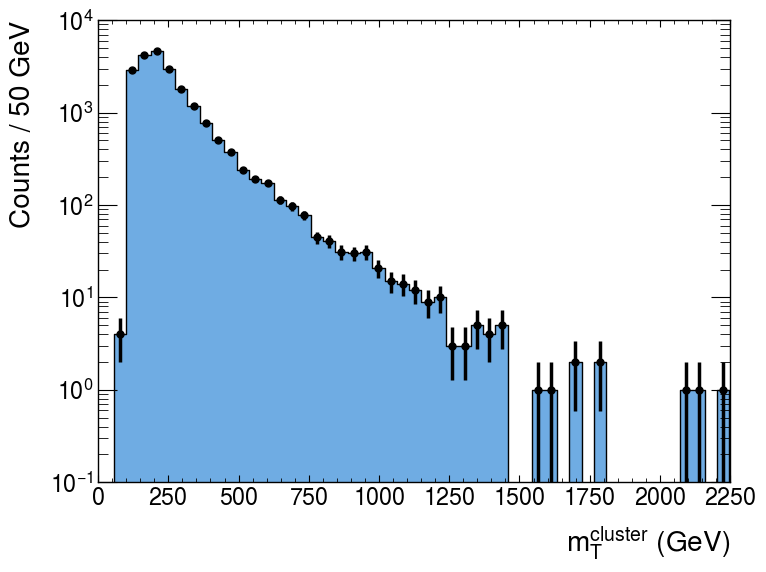

In [15]:
hep.style.use('ATLAS')
var=CMS_cut['Mt_cluster']

counts, bins = np.histogram(var, 50)
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
plt.figure()
sns.histplot(var,bins=50,element='step',edgecolor='black')
plt.errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
plt.yscale('log')
plt.ylabel('Counts / 50 GeV')
plt.xlabel(r'$\mathrm{m_{T}^{cluster}}$'+' (GeV)')
plt.show()

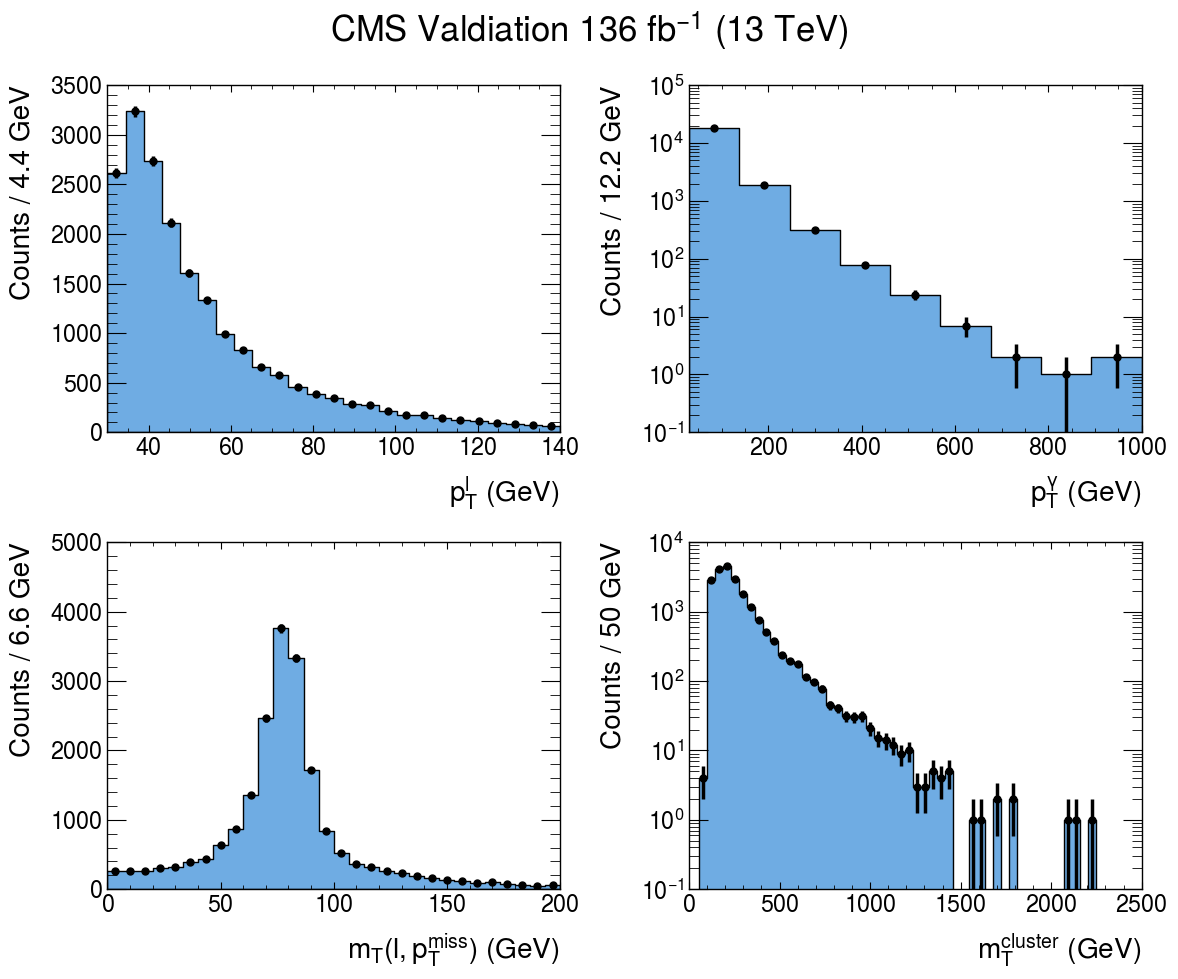

In [16]:
cross_section_inclusive=0.9957

cross_section_integrated=0.9957*len(CMS_cut)/FILE_SIZE *1000


fig,axes=plt.subplots(2,2,figsize=(12,10))


Pt_lepton=pd.concat([CMS_cut['Muon.PT'],CMS_cut['Electron.PT']],axis=0,ignore_index=True)
var=Pt_lepton

counts, bins = np.histogram(var, 25,range=(30, 140))
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(var,bins=25,element='step',binrange=[30,140],edgecolor='black',ax=axes[0][0])
axes[0][0].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')

axes[0][0].set_xlim(30,140)
axes[0][0].set_ylabel('Counts / 4.4 GeV')
axes[0][0].set_xlabel(r'$\mathrm{p_{T}^{l}}$'+' (GeV)')









Pt_photon=CMS_cut['Photon.PT']
var=Pt_photon

counts, bins = np.histogram(var, 9,range=(30, 1000))
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(var,bins=9,element='step',edgecolor='black',binrange=[30,1000],ax=axes[0][1])
axes[0][1].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
axes[0][1].set_yscale('log')
axes[0][1].set_ylabel('Counts / 12.2 GeV')
axes[0][1].set_xlabel(r'$\mathrm{p_{T}^{\gamma}}$'+' (GeV)')
axes[0][1].set_xlim(30,1000)






var=CMS_cut['Mt_lv']

counts, bins = np.histogram(var, 30,range=(0, 200))
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(var,bins=30,element='step',edgecolor='black',binrange=[0,200],ax=axes[1][0])
axes[1][0].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
axes[1][0].set_ylabel('Counts / 6.6 GeV')
axes[1][0].set_xlabel(r'$\mathrm{m_{T}(l,p_{T}^{miss})}$'+' (GeV)')






var=CMS_cut['Mt_cluster']

counts, bins = np.histogram(var, 50)
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(var,bins=50,element='step',edgecolor='black',ax=axes[1][1])
axes[1][1].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
axes[1][1].set_yscale('log')
axes[1][1].set_ylabel('Counts / 50 GeV')
axes[1][1].set_xlabel(r'$\mathrm{m_{T}^{cluster}}$'+' (GeV)')

plt.suptitle('CMS Valdiation '+r'$\mathrm{{ {:.0f} \ fb^{{-1}} }}$'.format(cross_section_integrated)+' (13 TeV)',size=25)


plt.tight_layout()
plt.show()



# Normalization

In [17]:
N_e=0.53*72798
N_mu=0.58*109669
N_CMS=N_e+N_mu
N_sim=len(CMS_cut)
Norm=N_CMS/N_sim
Norm

5.000291627929735

# Phi variable reconstruction

In [75]:
# large boost?

W_boson=particle.Particle.from_pdgid(24)
M_w=W_boson.mass/1000

CMS_cut['large_boost']=0.0
CMS_cut.loc[CMS_cut['Electron_size']==1,'large_boost']=M_w**2/(CMS_cut['Electron.PT']*CMS_cut['MissingET.MET'])
CMS_cut.loc[CMS_cut['Muon_size']==1,'large_boost']=M_w**2/(CMS_cut['Muon.PT']*CMS_cut['MissingET.MET'])

CMS_cut['delta']=0.0
CMS_cut.loc[CMS_cut['Electron_size']==1,'delta']=(M_w**2-CMS_cut['Mt_lv']**2)/(2*CMS_cut['Electron.PT']*CMS_cut['MissingET.MET'])
CMS_cut.loc[CMS_cut['Muon_size']==1,'delta']=(M_w**2-CMS_cut['Mt_lv']**2)/(2*CMS_cut['Muon.PT']*CMS_cut['MissingET.MET'])

<Axes: xlabel='large_boost', ylabel='Count'>

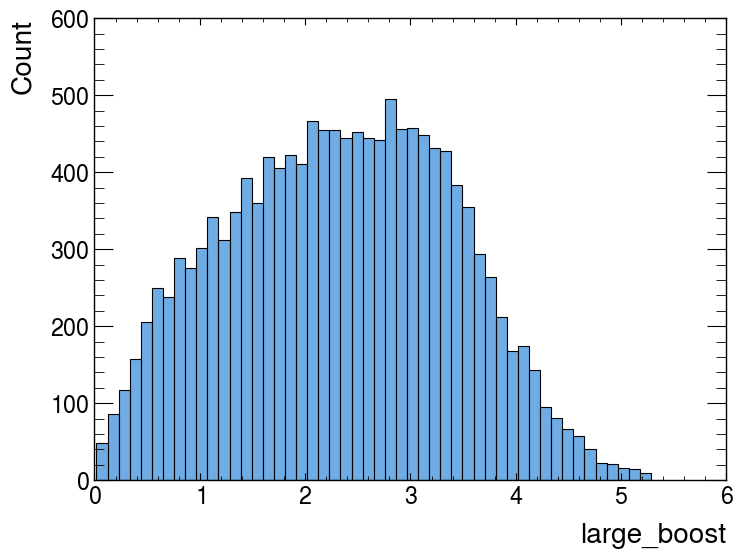

In [78]:
sns.histplot(CMS_cut['large_boost'],bins=50)

In [136]:
CMS_cut

,Muon_size,Muon.PT,Muon.Eta,Muon.Phi,Electron_size,Electron.PT,Electron.Eta,Electron.Phi,Photon_size,Photon.PT,...,MissingET_size,Jet_size,Jet.PT,Jet.Eta,lepton_mass,M_ly,Mt_lv,Mt_cluster,large_boost,delta
2,0,NaN,NaN,NaN,1,42.327488,0.159411,-0.901897,1,73.955528,...,1,0,NaN,NaN,0.000511,151.608697,56.479634,223.070528,2.298643,0.581714
4,1,32.553326,-1.909654,-2.742675,0,NaN,NaN,NaN,1,45.553852,...,1,0,NaN,NaN,0.105658,104.317234,77.966561,173.038718,3.738108,0.110072
8,1,35.918331,-0.658811,-2.950005,0,NaN,NaN,NaN,1,78.052620,...,1,0,NaN,NaN,0.105658,155.125921,16.179388,206.997393,3.934757,1.887646
33,0,NaN,NaN,NaN,1,36.643551,-1.840654,1.399533,1,54.415524,...,1,1,35.369308,-0.745326,0.000511,56.141336,78.217479,139.901772,3.957799,0.104534
59,0,NaN,NaN,NaN,1,37.737545,-1.400259,2.815280,1,36.196400,...,1,0,NaN,NaN,0.000511,61.239874,85.142148,132.771261,2.908726,-0.177880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99952,1,31.125347,-0.360664,0.908215,0,NaN,NaN,NaN,1,42.430138,...,1,0,NaN,NaN,0.105658,58.321007,71.022452,131.961051,3.762564,0.412125
99956,1,102.876854,-0.349944,-1.877518,0,NaN,NaN,NaN,1,158.243958,...,1,0,NaN,NaN,0.105658,348.534116,63.979282,422.422407,0.968050,0.177286
99969,0,NaN,NaN,NaN,1,41.569260,2.447925,-1.693291,1,71.971504,...,1,0,NaN,NaN,0.000511,179.383179,61.500761,239.819752,2.897420,0.600379
99972,1,57.916382,0.434552,-2.818321,0,NaN,NaN,NaN,1,187.687897,...,1,0,NaN,NaN,0.105658,376.745563,68.142392,528.366517,0.895069,0.125810


In [ ]:
CMS_cut.loc[CMS_cut['Electron_size']==1,'q_11']=np.array( [  CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']),CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']),CMS_cut['Electron.PT']*np.sinh(CMS_cut['Electron.Phi'])  ])
CMS_cut.loc[CMS_cut['Muon_size']==1,'q_11']=np.array( [  CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']),CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']),CMS_cut['Muon.PT']*np.sinh(CMS_cut['Muon.Phi'])  ])

CMS_cut['q_12']=np.array( [  CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi']),CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi']),CMS_cut['MissingET.MET']*np.sinh(CMS_cut['MissingET.Phi'])  ])



In [387]:
events_df

,Muon_size,Muon.PT,Muon.Eta,Muon.Phi,Electron_size,Electron.PT,Electron.Eta,Electron.Phi,Photon_size,Photon.PT,Photon.Eta,Photon.Phi,MissingET.MET,MissingET.Eta,MissingET.Phi,MissingET_size,Jet_size,Jet.PT,Jet.Eta
0,1,28.150805,-0.552860,0.345399,0,NaN,NaN,NaN,1,67.268318,-1.942108,2.796225,47.516922,3.154903,-0.549393,1,0,NaN,NaN
2,0,NaN,NaN,NaN,1,42.327488,0.159411,-0.901897,1,73.955528,1.855894,1.689297,66.387009,-2.413509,-2.025549,1,0,NaN,NaN
4,1,32.553326,-1.909654,-2.742675,0,NaN,NaN,NaN,1,45.553852,0.106345,2.121895,53.079880,1.841485,-0.310143,1,0,NaN,NaN
6,1,41.704430,-0.283276,1.523452,0,NaN,NaN,NaN,1,38.812653,0.361311,-2.759779,46.205620,-2.712186,-0.540400,1,0,NaN,NaN
8,1,35.918331,-0.658811,-2.950005,0,NaN,NaN,NaN,1,78.052620,1.212273,0.448808,45.702824,-2.538639,-2.547992,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149990,0,NaN,NaN,NaN,1,16.281570,-0.158424,-0.828824,1,41.580513,-1.602090,-0.929617,66.619850,0.873364,2.577739,1,1,22.517788,2.348555
149992,1,38.852169,1.838208,-3.007032,0,NaN,NaN,NaN,1,37.935162,0.793314,-1.388908,57.859573,-1.274684,0.756410,1,0,NaN,NaN
149993,0,NaN,NaN,NaN,1,37.793171,-1.456162,1.957093,1,35.784168,1.275605,-0.128440,52.077316,-2.378717,-1.996833,1,0,NaN,NaN
149996,1,34.302082,1.213099,-0.655622,0,NaN,NaN,NaN,1,140.512955,2.059631,-1.223741,117.786446,-4.036861,1.716460,1,1,71.201035,4.23502


# EFT selection

In [33]:
W_boson=particle.Particle.from_pdgid(24)
M_w=W_boson.mass/1000
EFT_cut=events_df.loc[(events_df['Photon.PT']>150 )  &   
                    (   (   (events_df['Electron_size']==1) & (events_df['Electron.PT']>80)   )  | 
                      (  (events_df['Muon_size']==1) & (events_df['Muon.PT']>80)     )     )   ].copy()
#EFT_cut=events_df.copy()

In [34]:
def is_valid_greater(value, threshold):
    if isinstance(value, np.ndarray):  # First check if it's an array
        return np.all(value >threshold)
    elif pd.isna(value):  # Then check if it's NaN (this will now only apply to non-arrays)
        return True  # Keep NaN values
    elif isinstance(value, (int, float)):  # Check if it's a scalar number
        return value >threshold
    return False
    
    
def is_valid_lesser(value, threshold):
    if isinstance(value, np.ndarray):  # First check if it's an array
        return np.all(value <threshold)
    elif pd.isna(value):  # Then check if it's NaN (this will now only apply to non-arrays)
        return True  # Keep NaN values
    elif isinstance(value, (int, float)):  # Check if it's a scalar number
        return value <threshold
    return False
    

EFT_cut = EFT_cut[EFT_cut['Jet.PT'].apply(lambda x: is_valid_greater(x, 30))]

EFT_cut = EFT_cut[EFT_cut['Jet.Eta'].apply(lambda x: is_valid_lesser(x, 2.5))]




In [35]:
EFT_cut['lepton_mass']=0.0
EFT_cut.loc[EFT_cut['Muon_size']==1,'lepton_mass']=particle.Particle.from_pdgid(13).mass/1000
EFT_cut.loc[EFT_cut['Electron_size']==1,'lepton_mass']=particle.Particle.from_pdgid(11).mass/1000
EFT_cut['Mt_lv']=0.0


EFT_cut.loc[EFT_cut['Electron_size']==1,'Mt_lv']=np.sqrt(  
    ( EFT_cut['MissingET.MET']+ np.sqrt((EFT_cut['Electron.PT'])**2+EFT_cut['lepton_mass']**2))**2 
    - (   EFT_cut['Electron.PT']*np.cos(EFT_cut['Electron.Phi']) +EFT_cut['MissingET.MET']*np.cos(EFT_cut['MissingET.Phi'])  )**2
        - (   EFT_cut['Electron.PT']*np.sin(EFT_cut['Electron.Phi']) +EFT_cut['MissingET.MET']*np.sin(EFT_cut['MissingET.Phi'])  )**2   )

EFT_cut.loc[EFT_cut['Muon_size']==1,'Mt_lv']=np.sqrt(  
    ( EFT_cut['MissingET.MET']+ np.sqrt((EFT_cut['Muon.PT'])**2+EFT_cut['lepton_mass']**2))**2 
    - (   EFT_cut['Muon.PT']*np.cos(EFT_cut['Muon.Phi']) +EFT_cut['MissingET.MET']*np.cos(EFT_cut['MissingET.Phi'])  )**2
        - (   EFT_cut['Muon.PT']*np.sin(EFT_cut['Muon.Phi']) +EFT_cut['MissingET.MET']*np.sin(EFT_cut['MissingET.Phi'])  )**2   )

In [36]:
EFT_cut['large_boost']=0.0
EFT_cut.loc[EFT_cut['Electron_size']==1,'large_boost']=M_w**2/(EFT_cut['Electron.PT']*EFT_cut['MissingET.MET'])
EFT_cut.loc[EFT_cut['Muon_size']==1,'large_boost']=M_w**2/(EFT_cut['Muon.PT']*EFT_cut['MissingET.MET'])

EFT_cut['delta']=0.0
EFT_cut.loc[EFT_cut['Electron_size']==1,'delta']=(M_w**2-EFT_cut['Mt_lv']**2)/(2*EFT_cut['Electron.PT']*EFT_cut['MissingET.MET'])
EFT_cut.loc[EFT_cut['Muon_size']==1,'delta']=(M_w**2-EFT_cut['Mt_lv']**2)/(2*EFT_cut['Muon.PT']*EFT_cut['MissingET.MET'])

<Axes: xlabel='large_boost', ylabel='Count'>

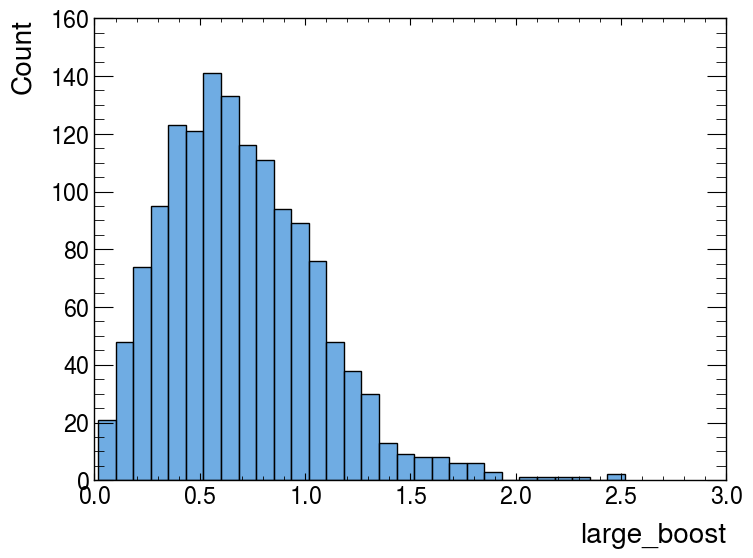

In [37]:
sns.histplot(EFT_cut['large_boost'],bins=30)

In [38]:
EFT_cut['sign']=np.sign(EFT_cut['delta'])

In [39]:
EFT_cut.loc[(EFT_cut['sign']==-1.0) & (EFT_cut['Electron_size']==1),'Eta_v']=EFT_cut['Electron.Eta']
EFT_cut.loc[(EFT_cut['sign']==-1.0) & (EFT_cut['Muon_size']==1),'Eta_v']=EFT_cut['Muon.Eta']

In [40]:
def random_eta(row):
    eta_plus = row['Electron.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    eta_minus = row['Electron.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    return np.random.choice([eta_plus, eta_minus])
EFT_cut.loc[(EFT_cut['Electron_size'] == 1) & (EFT_cut['delta'] >= 0), 'Eta_v'] = EFT_cut[(EFT_cut['Electron_size'] == 1) & (EFT_cut['delta'] >= 0)].apply(random_eta, axis=1)

In [41]:
def random_eta(row):
    eta_plus = row['Muon.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    eta_minus = row['Muon.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    return np.random.choice([eta_plus, eta_minus])
EFT_cut.loc[(EFT_cut['Muon_size'] == 1) & (EFT_cut['delta'] >= 0), 'Eta_v'] = EFT_cut[(EFT_cut['Muon_size'] == 1) & (EFT_cut['delta'] >= 0)].apply(random_eta, axis=1)

In [42]:
EFT_cut

,Muon_size,Muon.PT,Muon.Eta,Muon.Phi,Electron_size,Electron.PT,Electron.Eta,Electron.Phi,Photon_size,Photon.PT,...,MissingET_size,Jet_size,Jet.PT,Jet.Eta,lepton_mass,Mt_lv,large_boost,delta,sign,Eta_v
109,1,103.286194,0.550023,-0.668723,0,NaN,NaN,NaN,1,232.606079,...,1,1,56.957638,0.104295,0.105658,6.325384,0.509123,0.252985,1.0,-0.147091
131,1,111.371559,-0.975973,0.649034,0,NaN,NaN,NaN,1,152.208664,...,1,0,NaN,NaN,0.105658,24.796173,1.212193,0.548402,1.0,0.028542
139,0,NaN,NaN,NaN,1,155.396896,0.673563,-1.217973,1,193.309891,...,1,0,NaN,NaN,0.000511,47.219866,0.901263,0.295073,1.0,-0.076911
182,0,NaN,NaN,NaN,1,251.727676,-0.935996,-1.025789,1,290.899353,...,1,0,NaN,NaN,0.000511,168.135979,0.378165,-0.638470,-1.0,-0.935996
184,0,NaN,NaN,NaN,1,191.824677,0.271288,-0.440967,1,359.781158,...,1,0,NaN,NaN,0.000511,79.180531,0.194085,0.002849,1.0,0.346753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149778,0,NaN,NaN,NaN,1,194.601883,-1.657175,1.339820,1,259.719482,...,1,0,NaN,NaN,0.000511,77.239393,0.396606,0.015143,1.0,-1.830987
149785,1,90.342049,-0.282903,-0.772488,0,NaN,NaN,NaN,1,162.085587,...,1,0,NaN,NaN,0.105658,51.278870,1.097668,0.325404,1.0,0.503411
149845,1,119.782867,-1.598686,-1.965491,0,NaN,NaN,NaN,1,161.376328,...,1,0,NaN,NaN,0.105658,57.067820,0.981986,0.243433,1.0,-2.283012
149861,0,NaN,NaN,NaN,1,166.104034,-0.592216,-0.205589,1,208.253708,...,1,0,NaN,NaN,0.000511,9.867384,0.637865,0.314125,1.0,0.181000


In [43]:
EFT_cut['cot_Phi']=0.0
EFT_cut.loc[EFT_cut['Electron_size']==1,'cot_Phi']=(1/np.sin(EFT_cut['MissingET.Phi']-EFT_cut['Electron.Phi']))*(np.sinh(EFT_cut['Electron.Eta']-EFT_cut['Eta_v']) )#+EFT_cut['large_boost'])

EFT_cut.loc[EFT_cut['Muon_size']==1,'cot_Phi']=(1/np.sin(EFT_cut['MissingET.Phi']-EFT_cut['Muon.Phi']))*(np.sinh(EFT_cut['Muon.Eta']-EFT_cut['Eta_v']))#+EFT_cut['large_boost'])

<Axes: xlabel='cot_Phi', ylabel='Count'>

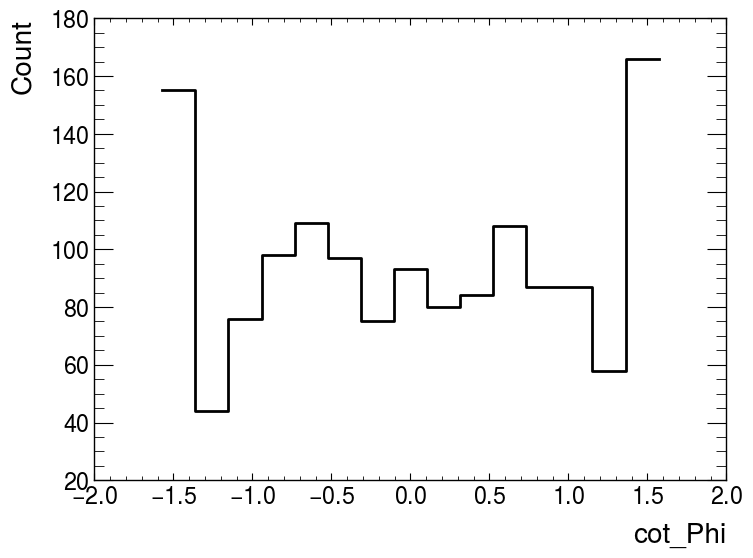

In [89]:
tan=1/EFT_cut['cot_Phi']
phi=np.arctan(tan)
sns.histplot(phi,bins=15,element='step',fill=None,color='black')#,stat='probability')


In [78]:
phi_copy=np.copy(phi)
phi=np.array(phi)
i=np.where(phi_copy<0)[0]
phi_copy[i]=phi_copy[i]+np.pi

j=np.where(phi_copy>0)[0]
phi_copy[j]=phi_copy[j]-np.pi
phi_rescale=np.hstack([phi,phi_copy])

In [79]:
phi_rescale

array([ 0.0741962 , -0.27593949, -0.57700994, ..., -0.72797729,
       -3.02722288, -0.01824933])

<Axes: xlabel='Electron.Eta', ylabel='Probability'>

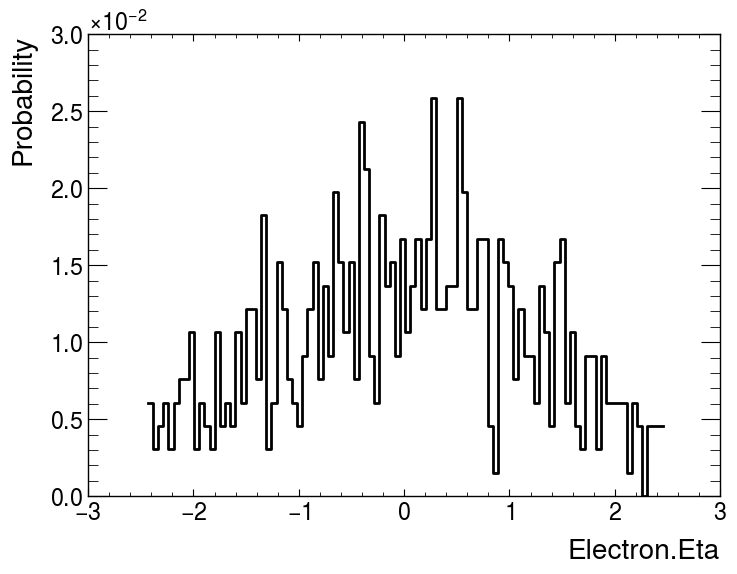

In [147]:
sns.histplot(EFT_cut['Electron.Eta'],bins=100,element='step',fill=None,color='black',stat='probability')


# Particle level studies

In [41]:
particle_level_features=['Particle.PID','Particle.M1','Particle.M2','Particle.D1','Particle.D2']
particle_level_df=tree.arrays(particle_level_features,library="pd")

In [42]:
particle_level_df

,Particle.PID,Particle.M1,Particle.M2,Particle.D1,Particle.D2
0,"[-1, 2, 21, 24, 22, 21, 21, 21, 21, 21, 21, 21...","[134, 135, 135, 0, 0, 10, 10, 11, 5, 5, 21, 39...","[-1, -1, -1, 1, 1, -1, -1, -1, 7, 7, -1, -1, -...","[3, 3, 147, 136, 137, 8, 42, 8, 12, 13, 5, 7, ...","[4, 4, 148, 136, 137, 9, 42, 9, 12, 13, 6, 7, ..."
1,"[1, -2, 21, -24, 22, 1, -2, 21, -24, 22, 21, 2...","[5, 6, 6, 0, 0, 12, 14, 14, 3, 4, 2, 2, 13, 21...","[-1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1,...","[3, 3, 10, 8, 9, 0, 1, 21, 15, 16, 17, 18, 5, ...","[4, 4, 11, 8, 9, 0, 2, 21, 15, 16, 17, 18, 5, ..."
2,"[2, -1, 21, 24, 22, 2, -1, 21, 24, 22, -4, 4, ...","[5, 6, 6, 0, 0, 12, 19, 19, 3, 4, 2, 2, 18, 42...","[-1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1,...","[3, 3, 10, 8, 9, 0, 1, 64, 21, 22, 23, 24, 5, ...","[4, 4, 11, 8, 9, 0, 2, 64, 21, 22, 23, 24, 5, ..."
3,"[-1, 2, 21, 24, 22, 2, 21, 21, 2, 21, 21, 21, ...","[26, 27, 27, 0, 0, 15, 16, 16, 5, 5, 33, 35, 3...","[-1, -1, -1, 1, 1, -1, -1, -1, 6, 6, -1, -1, -...","[3, 3, 274, 28, 29, 8, 8, 25, 18, 19, 13, 13, ...","[4, 4, 275, 28, 29, 9, 9, 25, 18, 19, 14, 14, ..."
4,"[-4, 4, 3, -24, 22, 21, 2, 3, -24, 22, 2, 21, ...","[5, 5, 7, 0, 0, 10, 10, 12, 3, 4, 16, 16, 17, ...","[-1, -1, -1, 2, 2, -1, -1, -1, -1, -1, -1, -1,...","[3, 15, 3, 8, 9, 0, 22, 2, 13, 14, 5, 30, 7, 1...","[4, 15, 4, 8, 9, 1, 22, 2, 13, 14, 6, 30, 7, 1..."
...,...,...,...,...,...
99995,"[2, -1, 1, 24, 22, 21, 21, -2, 21, -2, 21, -2,...","[15, 16, 16, 0, 0, 10, 10, 11, 5, 5, 67, 68, 6...","[-1, -1, -1, 1, 1, -1, -1, -1, 7, 7, -1, -1, -...","[3, 3, 33, 18, 19, 8, 36, 8, 13, 14, 5, 7, 81,...","[4, 4, 33, 18, 19, 9, 36, 9, 13, 14, 6, 7, 82,..."
99996,"[-4, 4, 3, 11, -12, 22, 21, 2, 3, 11, -12, 22,...","[6, 6, 8, 0, 0, 0, 12, 12, 13, 3, 4, 5, 19, 20...","[-1, -1, -1, 2, 2, 2, -1, -1, -1, -1, -1, -1, ...","[3, 18, 3, 9, 10, 11, 0, 26, 2, 15, 16, 17, 6,...","[5, 18, 5, 9, 10, 11, 1, 26, 2, 15, 16, 17, 7,..."
99997,"[2, 21, -1, 24, 22, 2, 21, -1, 24, 22, 21, 21,...","[5, 5, 7, 0, 0, 92, 92, 93, 3, 4, 25, 27, 27, ...","[-1, -1, -1, 2, 2, -1, -1, -1, -1, -1, -1, -1,...","[3, 96, 3, 8, 9, 0, 344, 2, 94, 95, 13, 13, 35...","[4, 96, 4, 8, 9, 1, 344, 2, 94, 95, 14, 14, 35..."
99998,"[-1, 2, -2, 24, 22, -1, 21, 21, 24, 22, -1, 21...","[5, 6, 6, 0, 0, 10, 12, 12, 3, 4, 16, 16, 17, ...","[-1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1,...","[3, 3, 15, 8, 9, 0, 1, 22, 13, 14, 5, 23, 6, 1...","[4, 4, 15, 8, 9, 0, 2, 22, 13, 14, 5, 24, 7, 1..."


In [38]:
test=np.array(particle_level_df['Particle.PID'][1])

In [48]:
a=particle.Particle.from_pdgid(92)
a.name

ParticleNotFound: Could not find PDGID 92

In [39]:
names=[]
def latex_to_matplotlib(latex_name):
    # Matplotlib uses LaTeX within dollar signs
    return f"${latex_name}$"
for i in test:
    names.append(latex_to_matplotlib(particle.Particle.from_pdgid(i).latex_name))
names=np.array(names)
np.unique(names)

array(['$(ud)_{0}$', '$(uu)_{1}$', '$K^{*}(892)^{+}$', '$K^{*}(892)^{-}$',
       '$K^{+}$', '$K^{-}$', '$K^{0}$', '$K_{L}^{0}$', '$K_{S}^{0}$',
       '$W^{-}$', '$\\Sigma^{+}$', '$\\eta$', '$\\eta^\\prime(958)$',
       '$\\gamma$', '$\\mu^{-}$', '$\\omega(782)$',
       '$\\overline{K}^{*}(892)^{0}$', '$\\overline{K}^{0}$',
       '$\\overline{\\Sigma}^{-}$', '$\\overline{\\nu}_{\\mu}$',
       '$\\overline{d}$', '$\\overline{n}$', '$\\overline{p}$',
       '$\\overline{u}$', '$\\phi(1020)$', '$\\pi^{+}$', '$\\pi^{-}$',
       '$\\pi^{0}$', '$\\rho(770)^{+}$', '$\\rho(770)^{-}$',
       '$\\rho(770)^{0}$', '$d$', '$e^{+}$', '$e^{-}$', '$g$', '$n$',
       '$p$', '$u$'], dtype='<U27')

In [40]:
from collections import Counter
counter=Counter(names)
sorted_elements = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# Display the elements with their frequencies
for element, frequency in sorted_elements:
    print(f"Element: {element}, Frequency: {frequency}")

Element: $g$, Frequency: 294
Element: $\gamma$, Frequency: 158
Element: $\pi^{0}$, Frequency: 72
Element: $\pi^{+}$, Frequency: 64
Element: $\pi^{-}$, Frequency: 62
Element: $d$, Frequency: 21
Element: $\overline{d}$, Frequency: 14
Element: $\rho(770)^{0}$, Frequency: 14
Element: $\rho(770)^{-}$, Frequency: 14
Element: $\overline{u}$, Frequency: 12
Element: $\omega(782)$, Frequency: 11
Element: $\eta$, Frequency: 9
Element: $p$, Frequency: 7
Element: $u$, Frequency: 6
Element: $\rho(770)^{+}$, Frequency: 6
Element: $W^{-}$, Frequency: 5
Element: $n$, Frequency: 5
Element: $K_{S}^{0}$, Frequency: 5
Element: $K^{*}(892)^{+}$, Frequency: 4
Element: $\overline{K}^{0}$, Frequency: 4
Element: $\overline{n}$, Frequency: 4
Element: $\overline{p}$, Frequency: 4
Element: $K^{0}$, Frequency: 4
Element: $K_{L}^{0}$, Frequency: 3
Element: $(ud)_{0}$, Frequency: 2
Element: $(uu)_{1}$, Frequency: 2
Element: $\mu^{-}$, Frequency: 2
Element: $\overline{\nu}_{\mu}$, Frequency: 2
Element: $\eta^\prime(95

# Lorentz boost

In [90]:
import vector

In [220]:
P_l=vector.zip({'pt':EFT_cut['Electron.PT'].loc[EFT_cut['Electron_size']==1] ,'eta':EFT_cut['Electron.Eta'].loc[EFT_cut['Electron_size']==1],
                'phi':EFT_cut['Electron.Phi'].loc[EFT_cut['Electron_size']==1],'mass':EFT_cut['lepton_mass'].loc[EFT_cut['Electron_size']==1]  })
P_y=vector.zip({'pt':EFT_cut['Photon.PT'].loc[EFT_cut['Electron_size']==1] ,'eta':EFT_cut['Photon.Eta'].loc[EFT_cut['Electron_size']==1],
                'phi':EFT_cut['Photon.Phi'].loc[EFT_cut['Electron_size']==1],'mass':0 })

P_vl=vector.zip({'pt':EFT_cut['MissingET.MET'].loc[EFT_cut['Electron_size']==1] ,'eta':EFT_cut['Eta_v'].loc[EFT_cut['Electron_size']==1],
                'phi':EFT_cut['MissingET.Phi'].loc[EFT_cut['Electron_size']==1],'mass':0 })


P_w=P_l+P_vl

In [222]:
Boost_frame_1=-vector.zip({'px':(P_w+P_y).px/(P_w+P_y).E,'py':(P_w+P_y).py/(P_w+P_y).E,'pz':(P_w+P_y).pz/(P_w+P_y).E})

P_w_boosted=P_w.boost_beta3(Boost_frame_1)
P_y_boosted=P_y.boost_beta3(Boost_frame_1)

In [223]:
P_l_boosted_1=P_l.boost_beta3(Boost_frame_1)
P_vl_boosted_1=P_vl.boost_beta3(Boost_frame_1)


Boost_frame_2=-vector.zip({'px':P_w_boosted.px/P_w_boosted.E,'py':P_w_boosted.py/P_w_boosted.E,'pz':P_w_boosted.pz/P_w_boosted.E})

P_l_boosted_2=P_l_boosted_1.boost_beta3(Boost_frame_2)
P_vl_boosted_2=P_vl_boosted_1.boost_beta3(Boost_frame_2)

In [246]:
z_axis=vector.zip({'px':P_w_boosted.px/P_w_boosted.E,'py':P_w_boosted.py/P_w_boosted.E,'pz':P_w_boosted.pz/P_w_boosted.E})
fermion_line=vector.zip({'px':P_vl_boosted_2.px/P_vl_boosted_2.E,'py':P_vl_boosted_2.py/P_vl_boosted_2.E,'pz':P_vl_boosted_2.pz/P_vl_boosted_2.E})


In [247]:
n1=z_axis.cross(Boost_frame_1)/(z_axis.cross(Boost_frame_1).mag)
n2=fermion_line.cross(Boost_frame_2)/(fermion_line.cross(Boost_frame_2).mag)

In [232]:
test=(n1.dot(n2))/(n1.mag*n2.mag)

In [240]:
n2

<MomentumArray3D [{x: 0.645, y: 0.758, z: ..., ...}, ...] type='759 * Momen...'>

In [241]:
n2_prime

<MomentumArray3D [{x: 0.645, y: 0.758, z: ..., ...}, ...] type='759 * Momen...'>

In [1]:
#test tets tes

In [2]:
import numpy as np
